In [12]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
import sys
import warnings
warnings.filterwarnings('ignore')

import time

from scipy.stats import ks_2samp


from astropy.table import Table

homedir = os.getenv("HOME")

In [86]:
from scipy.optimize import curve_fit
def gaussian(x,amplitude,center,sigma):
    return amplitude*(1/(sigma*(np.sqrt(2*np.pi))))*np.exp((-1.0/2.0)*((x-center)/sigma)**2)

def twogaussian(x_array, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen2)/sigma2)**2)))

def threegaussian(x_array, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen2)/sigma2)**2))) +\
            amp3*(1/(sigma3*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen3)/sigma3)**2)))

def gaussian1(x_array, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2))) 

def solve(m1,m2,std1,std2,amp1,amp2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1*amp1/amp2)
  return np.roots([a,b,c])

In [170]:
def separate_sf(x,y,m1=9,m2=10.8,ms_slope=0.56,ms_intercept=-5.74,dm=.15,nbins=20,twogauss=True):

    lowmass=m1
    highmass=m2
    minmass = np.arange(lowmass,highmass,dm)
    maxmass = np.arange(lowmass+dm,highmass+dm,dm)

    histbins=np.linspace(-3,1,nbins)
    plt.figure(figsize=(12,10))
    plt.subplots_adjust(hspace=.5)
    nplot=1
    sfrcut_mass = []
    sfrcut_sfr = []
    lower_peak_sfr = []
    higher_peak_sfr = []
    higher_peak_std = []
    for m1,m2 in zip(minmass,maxmass):
        plt.subplot(4,4,nplot)
        flag = (x > m1) & (x < m2)
        # plot the data
        ybin,xbin_edge,t=plt.hist(y[flag],histtype='step',bins=histbins)
        xbin = (xbin_edge[:-1]+xbin_edge[1:])/2
        plt.title(r'$\rm {:.2f} < logMstar < {:.2f}$'.format(m1,m2),fontsize=14)
        

        xatmax= xbin[ybin == np.max(ybin)]
        xline=np.linspace(min(xbin),max(xbin),50)
        try:
            if twogauss:
                popt,pcov = curve_fit(twogaussian,xbin,ybin)
                yline = twogaussian(xline,*popt)
                plt.plot(xline,gaussian1(xline,popt[0],popt[1],popt[2]),'b')
                plt.plot(xline,gaussian(xline,popt[3],popt[4],popt[5]),'c-')
            else:
                popt,pcov = curve_fit(threegaussian,xbin,ybin)
                yline = threegaussian(xline,*popt)
                plt.plot(xline,gaussian1(xline,popt[0],popt[1],popt[2]),'b')
                plt.plot(xline,gaussian(xline,popt[3],popt[4],popt[5]),'c-')
                plt.plot(xline,gaussian(xline,popt[6],popt[7],popt[8]),'g-')
        except:
            continue
        # plot combined gaussian
        plt.plot(xline,yline,'r-')
        # plot the two gaussians individually
        
        # find intersection of two gaussians
        # solve(m1,m2,std1,std2)
        intersection = solve(popt[1],popt[4],popt[2],popt[5],popt[0],popt[3])
        
        # gaussians will likely have two points of intersection
        # use the minimum
        # if both are negative, then take the max
        if len(intersection) == 2:
            if (intersection[0] < 0) & (intersection[1] < 0):
                sfr = np.max(intersection)
            else:
                sfr = np.min(intersection)
        

            plt.axvline(x=sfr, ls='--',c='k')
            sfrcut_mass.append(0.5*(m1+m2))
            sfrcut_sfr.append(sfr)
           
            
            lower_peak_sfr.append(np.min([popt[1],popt[4]]))
            higher_peak_sfr.append(np.max([popt[1],popt[4]]))
            if popt[1] > popt[4]:
                higher_peak_std.append(popt[2])
            else:
                higher_peak_std.append(popt[5])
    
        plt.xlabel('SFR',fontsize=10)
        # add vertical line showing sSFR = -11.5
        sfr_limit = 0.5*(m1+m2) - 11.5
        plt.axvline(x=sfr_limit,ls=':')
        nplot += 1
    

    sfrcut_mass = np.array(sfrcut_mass)
    sfrcut_sfr = np.array(sfrcut_sfr)
    higher_peak_std = np.array(higher_peak_std)
    higher_peak_sfr = np.array(higher_peak_sfr)
    # plot peak of SF gaussian vs mass

    plt.figure()
    plt.plot(sfrcut_mass,higher_peak_sfr,'bo')
    # fit the sf main sequence
    flag = (sfrcut_mass < 10.3) & (sfrcut_mass > 8)
    c,cov = np.polyfit(sfrcut_mass[flag],higher_peak_sfr[flag],1,cov=True)
    xline = np.linspace(lowmass,highmass,100)
    yline = np.polyval(c,xline)
    plt.plot(xline,yline,'r--')
    plt.xlabel('log Mass')
    plt.ylabel('Center of SF peak')
    print('SFR-Mstar best fit line : ',c)
    print("sqrt of cov matrix = ",np.sqrt([cov[0][0],cov[1][1]]))


    # plot 
    plt.figure()
    plt.plot(sfrcut_mass,sfrcut_sfr,'bo')
    plt.xlabel('log Mass')
    plt.ylabel('SFR where gaussians intersect')
    print("average SFR of where gaussians overlap = {:.2f}".format(np.mean(sfrcut_sfr)))
    print("median SFR of where gaussians overlap = {:.2f}".format(np.median(sfrcut_sfr)))

    # plot offset from the MS
    plt.figure()
    sfroffset = sfrcut_sfr - (ms_slope*sfrcut_mass + ms_intercept)
    plt.plot(sfrcut_mass,sfroffset,'bo')
    plt.xlabel('log Mass')
    plt.ylabel('SFR offset from MS')

    print('mean offset from MS = {:.2f}'.format(np.mean(sfroffset[sfrcut_mass > 9.7])))
    print('median offset from MS = {:.2f}'.format(np.median(sfroffset[sfrcut_mass > 9.7])))


    # plot std from the MS
    plt.figure()

    plt.plot(sfrcut_mass,higher_peak_std,'bo')
    plt.xlabel('log Mass')
    plt.ylabel('STD of MS')

    print('mean STD of MS = {:.2f}'.format(np.mean(higher_peak_std)))
    print('median STD of MS = {:.2f}'.format(np.median(higher_peak_std)))

    # plot std from the MS
    plt.figure()

    plt.plot(sfrcut_mass,sfroffset/higher_peak_std,'bo')
    plt.xlabel('log Mass')
    plt.ylabel('Offset from MS / STD of MS')

    print('median Zscore of offset = {:.2f}'.format(np.median(sfroffset/higher_peak_std)))


In [5]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py --ellip 0.75 --minmass 9.7 --minssfr -14 

Running on coma
outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
number of lines in LCS cat =  2955
got sb flag
2759 2759 2759 2759
STD of pruned data = 0.16
STD of full data = 0.17
##################################
### FITTING WITH SIGMA CLIPPING 
##################################
Best-fit slope = 0.49
Best-fit inter = -5.01
Width of the MS = 0.17 (unclipped data)
###################################
### FITTING MS AFTER SIGMA CLIPPING 
###################################
Best-fit slope = 0.49+/-0.05
Best-fit inter = -5.01+/-0.49


outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
number of lines in LCS cat =  2955
got sb flag
2759 2759 2759 2759
STD of pruned data = 0.15
STD of full data = 0.16
##################################
### FITTING WITH SIGMA CLIPPING 
##################################
Best-fit slope = 0.59
Best-fit inter = -6.06
Width of the MS = 0.16 (unclipped data)
###################################
### FITTING MS AFTER SIGMA CLIPPING 
###################################
Best-fit slope = 0.59+/-0.03
Best-fit inter = -6.06+/-0.30


<Figure size 489.6x360 with 0 Axes>

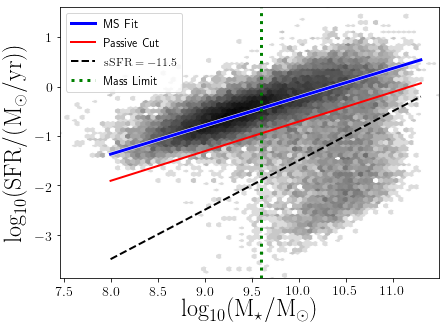

In [11]:
# plot main sequence
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.6 --ellip 0.75 --HIdef --minssfr -11.5
b.plot_full_ms()



# Using sample from paper

SFR-Mstar best fit line :  [ 0.59182938 -6.04994756]
sqrt of cov matrix =  [0.00942527 0.09150283]
average SFR of where gaussians overlap = -0.52
median SFR of where gaussians overlap = -0.52
mean offset from MS = -0.71
median offset from MS = -0.63
mean STD of MS = 0.29
median STD of MS = 0.29
median Zscore of offset = -1.91


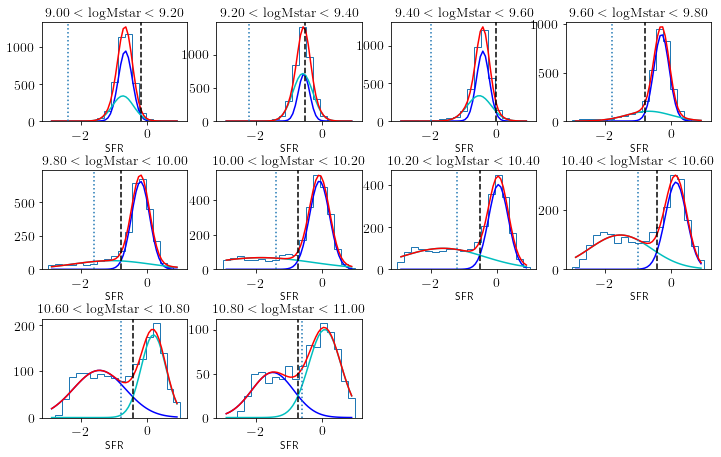

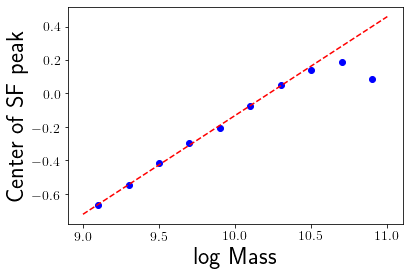

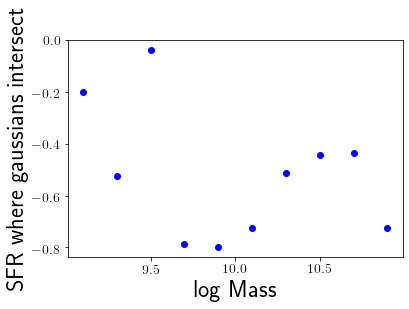

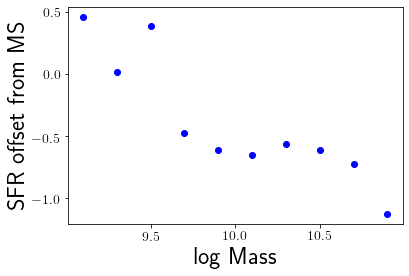

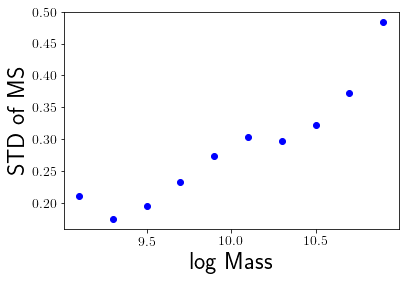

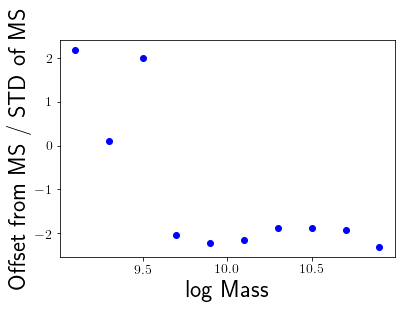

In [163]:
separate_sf(b.gsw.cat['logMstar'],b.gsw.cat['logSFR'],m1=9.,m2=11,ms_slope=0.592,ms_intercept=-6.05,dm=.2)

# Using sample from the paper, with B/T cut

SFR-Mstar best fit line :  [ 0.57851263 -5.93237612]
sqrt of cov matrix =  [0.00674775 0.06584816]
average SFR of where gaussians overlap = -0.56+0.04j
median SFR of where gaussians overlap = -0.58+0.08j
mean offset from MS = -0.59+0.05j
median offset from MS = -0.65+0.00j
mean STD of MS = 0.34
median STD of MS = 0.30
median Zscore of offset = -1.50+0.00j


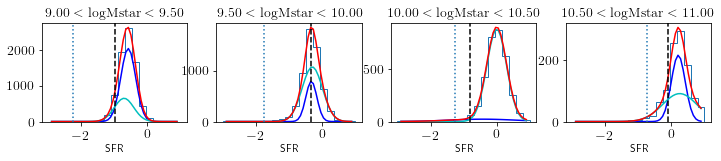

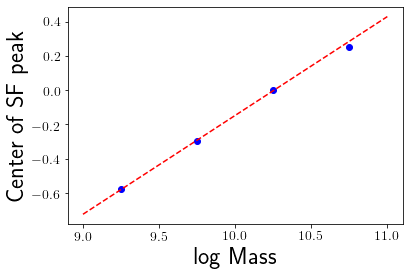

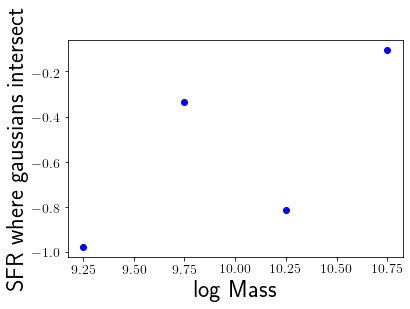

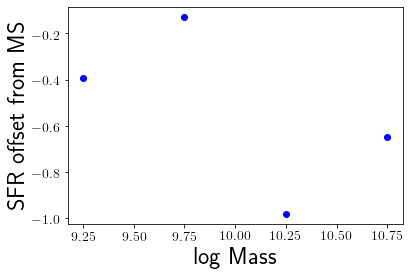

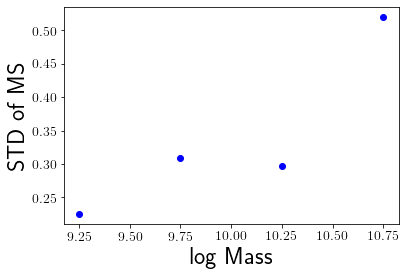

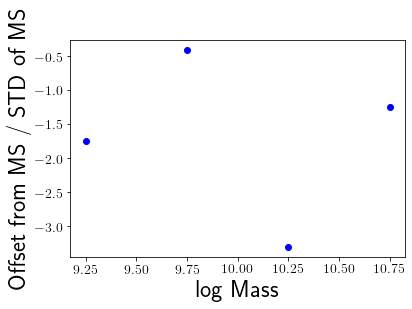

In [173]:
flag = b.gsw.cat['__B_T_r'] < 0.3
gswBTcut = b.gsw.cat[flag]
separate_sf(gswBTcut['logMstar'],gswBTcut['logSFR'],m1=9.,m2=11,ms_slope=0.754,ms_intercept=-7.56,dm=.5)

# Using GSWLC, cut in redshift only

But we have already excluded a large part of the passive sequence because we have removed AGN.  What if we repeat the same procedure, but we use the full GSWLC, just limiting to the redshift range of the LCS.

In [13]:
gswlcs = Table.read(homedir+'/research/GSWLC/GSWLC-X2-LCS-Zoverlap.dat')

SFR-Mstar best fit line :  [ 0.55297857 -5.71285095]
sqrt of cov matrix =  [0.00780223 0.07574594]
average SFR of where gaussians overlap = -0.56
median SFR of where gaussians overlap = -0.58
mean offset from MS = -0.64
median offset from MS = -0.64
mean STD of MS = 0.30
median STD of MS = 0.30
median Zscore of offset = -1.83


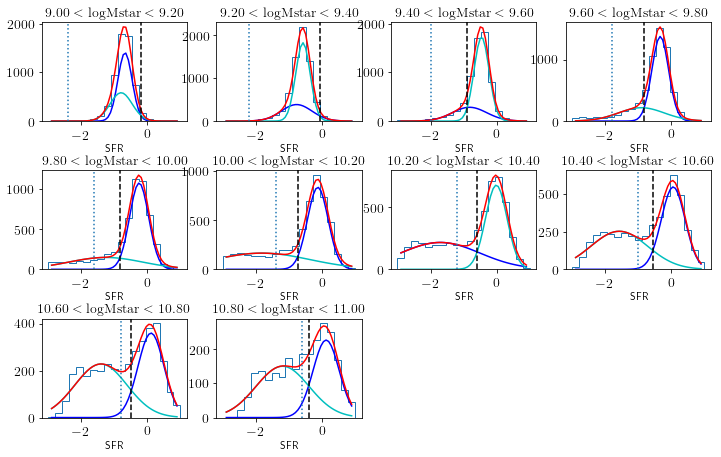

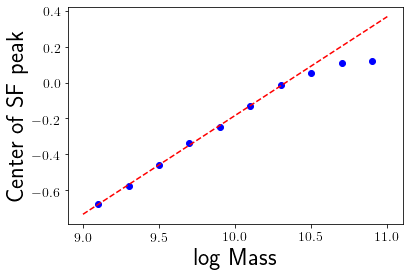

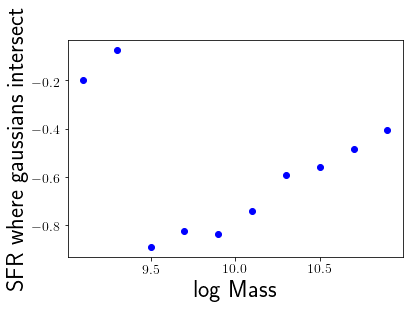

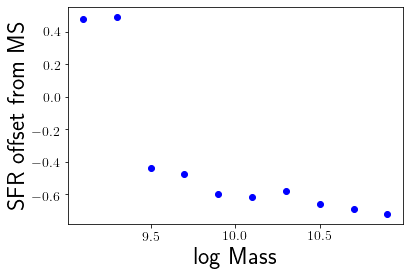

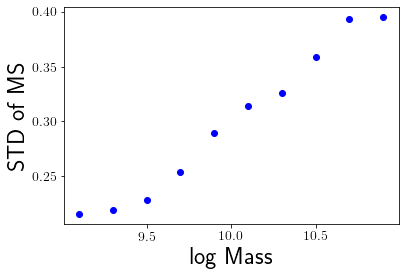

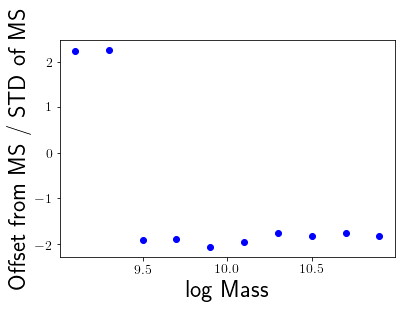

In [167]:
separate_sf(gswlcs['logMstar'],gswlcs['logSFR'],m1=9.,m2=11,ms_slope=.553,ms_intercept=-5.71,dm=.2)

# Using full GSWLC

In [66]:
gsw = Table.read(homedir+'/research/GSWLC/GSWLC-X2.dat',format='ascii')

SFR-Mstar best fit line :  [ 0.7988648 -7.92889  ]
sqrt of cov matrix =  [0.03095352 0.30050428]
average SFR of where gaussians overlap = -0.57
median SFR of where gaussians overlap = -0.57
mean offset from MS = -0.92
median offset from MS = -0.86
mean STD of MS = 0.37
median STD of MS = 0.31
median Zscore of offset = -2.05


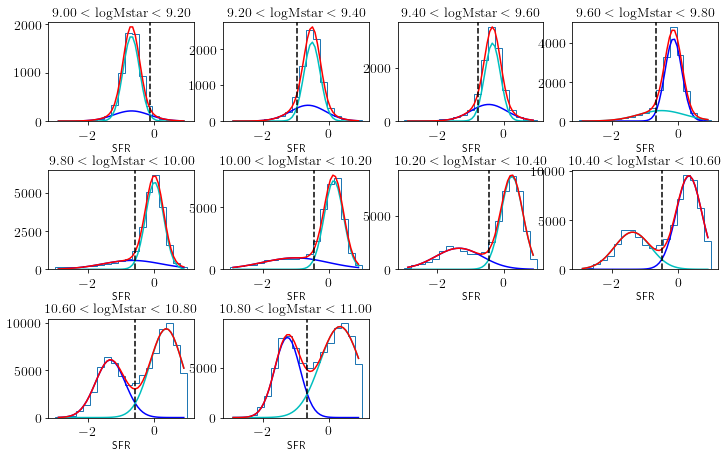

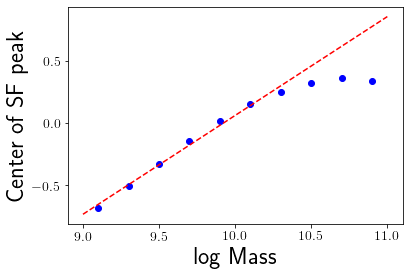

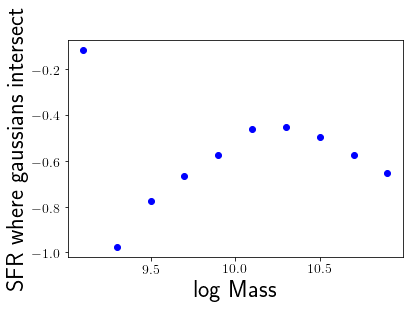

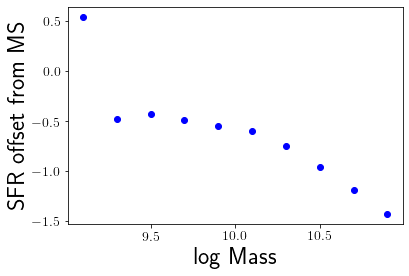

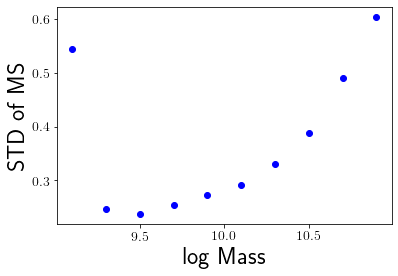

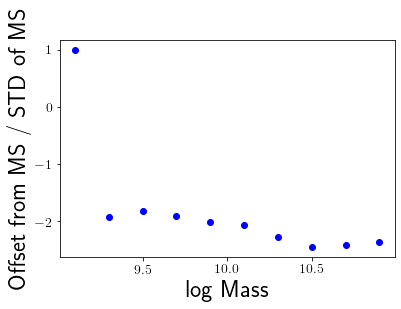

In [159]:
separate_sf(gsw['logMstar'],gsw['logSFR'],m1=9,m2=11,ms_slope=.799,ms_intercept=-7.93,dm=.2)

# Summary of fits

Text(0, 0.5, 'logSFR')

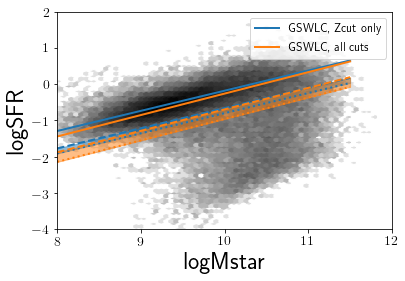

In [161]:
mycolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure()
plt.hexbin(gswlcs['logMstar'],gswlcs['logSFR'],cmap='gray_r',gridsize=75,bins='log')
xline = np.linspace(8,11.5,100)
# from GSWLC with LCS z cut
yline = .556*xline-5.74
STD = 0.32
offset = -0.62
plt.plot(xline,yline,lw=2,c=mycolors[0],label='GSWLC, Zcut only')
plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[0])
plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[0])
plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[0],alpha=.5)

# from GSWLC, cut according to AGC, Simard, etc
STD = 0.29
offset = -0.7
yline = 0.592*xline -6.18
plt.plot(xline,yline,lw=2,c=mycolors[1],label='GSWLC, all cuts')
plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[1])
plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[1])
plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[1],alpha=.5)
plt.legend()


# from full GSWLC
STD = 0.3
offset = -0.82
yline = 0.799*xline -7.92
#plt.plot(xline,yline,lw=2,c=mycolors[2],label='GSWLC')
#plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[2])
#plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[2])
#plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[2],alpha=.5)
plt.legend()
plt.axis([8,12,-4,2])
plt.xlabel('logMstar')
plt.ylabel('logSFR')

No handles with labels found to put in legend.


[8, 12, -4, 2]

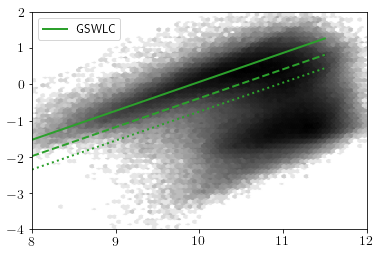

In [157]:
mycolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure()
plt.hexbin(gsw['logMstar'],gsw['logSFR'],cmap='gray_r',gridsize=75,bins='log',extent=(8,12,-4,2))
xline = np.linspace(8,11.5,100)
# from GSWLC with LCS z cut
yline = .556*xline-5.74
STD = 0.32
offset = -0.62
#plt.plot(xline,yline,lw=2,c=mycolors[0],label='GSWLC, Zcut only')
#plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[0])
#plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[0])
#plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[0],alpha=.5)

# from GSWLC, cut according to AGC, Simard, etc
STD = 0.29
offset = -0.7
yline = 0.592*xline -6.18
#plt.plot(xline,yline,lw=2,c=mycolors[1],label='GSWLC, all cuts')
#plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[1])
#plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[1])
#plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[1],alpha=.5)
plt.legend()


# from full GSWLC
STD = 0.3
offset = -0.82
yline = 0.799*xline -7.92
plt.plot(xline,yline,lw=2,c=mycolors[2],label='GSWLC')
plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[2])
plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[2])
#plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[2],alpha=.5)
plt.legend()
plt.axis([8,12,-4,2])

SFR-Mstar best fit line :  [ 0.84040107 -8.57044881]
sqrt of cov matrix =  [0.17484143 1.70619768]
average SFR of where gaussians overlap = -0.66
median SFR of where gaussians overlap = -0.55
mean offset from MS = -0.83
median offset from MS = -0.63
mean STD of MS = 0.43
median STD of MS = 0.28
median Zscore of offset = -1.26


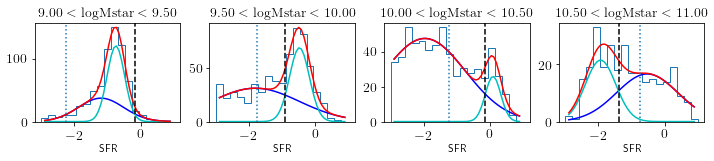

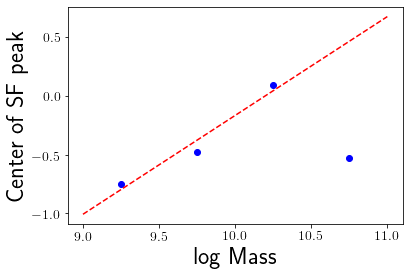

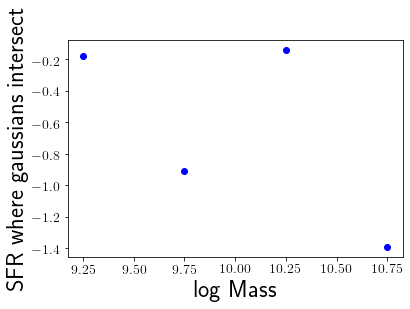

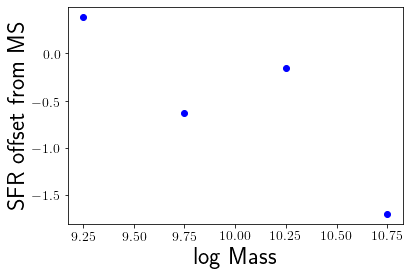

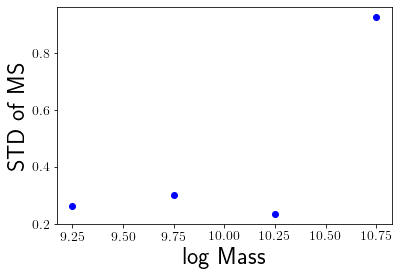

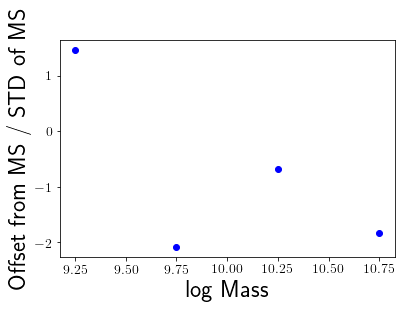

In [171]:
separate_sf(b.lcs.cat['logMstar'],b.lcs.cat['logSFR'],m1=9.,m2=11,ms_slope=0.592,ms_intercept=-6.05,dm=.5)

SFR-Mstar best fit line :  [ 0.72981341 -7.49885389]
sqrt of cov matrix =  [0.08475947 0.82712898]
average SFR of where gaussians overlap = -0.43
median SFR of where gaussians overlap = -0.42
mean offset from MS = -0.65
median offset from MS = -0.77
mean STD of MS = 0.23
median STD of MS = 0.25
median Zscore of offset = -2.59


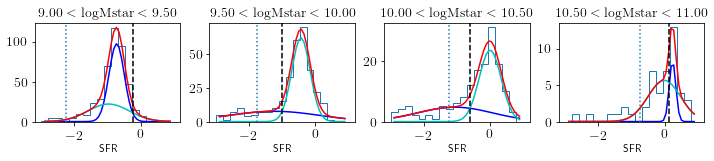

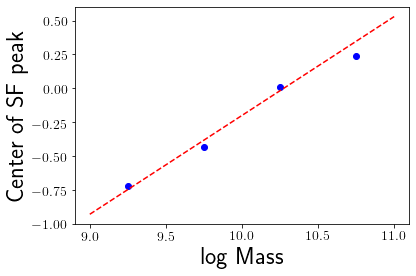

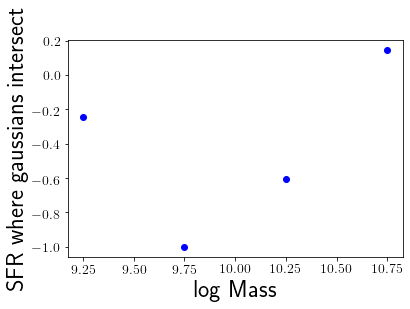

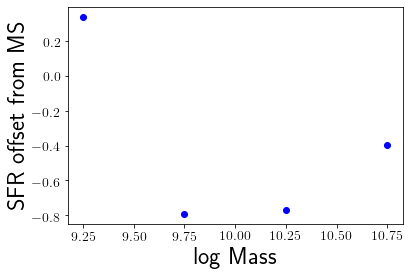

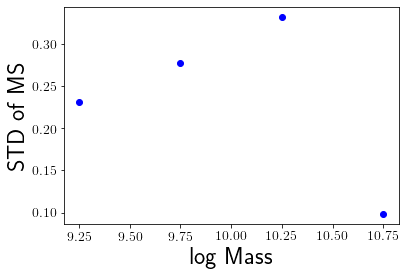

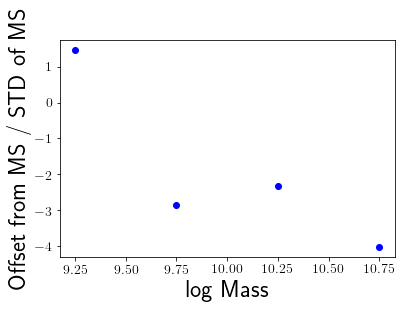

In [172]:
flag = b.lcs.cat['__B_T_r'] < 0.3
lcsBTcut = b.lcs.cat[flag]
separate_sf(lcsBTcut['logMstar'],lcsBTcut['logSFR'],m1=9.,m2=11,ms_slope=0.754,ms_intercept=-7.56,dm=.5)